In [1]:
# %load_ext ipycache

In [13]:
import os
import sys
# sys.path.insert(0,'/home/junwoony/.local/lib/python3.6/site-packages')
# sys.path.insert(0,'/home/zulissi/software/adamwr')
import numpy as np
#Select which GPU to use if necessary
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
%env CUDA_LAUNCH_BLOCKING=1
import mongo
# from torchviz import make_dot, make_dot_from_trace
import time
from torch.nn.utils import clip_grad_norm_
import pickle
import random
from torch.utils.data import Dataset, DataLoader
import mongo
# from cgcnn.data_icgcnn import StructureData, ListDataset, StructureDataTransformer
from cgcnn.data_grad_surface2_orbital import StructureData, ListDataset, StructureDataTransformer, collate_pool, MergeDataset
import numpy as np
import tqdm
from sklearn.preprocessing import StandardScaler
from pymatgen.io.ase import AseAtomsAdaptor

import multiprocess as mp
from sklearn.model_selection import ShuffleSplit
import copy
import matplotlib.pyplot as plt

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0
env: CUDA_LAUNCH_BLOCKING=1


In [2]:
SDT_training = pickle.load(open('./surface_orbital/SDT_training.pkl', 'rb'))
SDT_test = pickle.load(open('./surface_orbital/SDT_test.pkl', 'rb'))
target_training = pickle.load(open('./surface_orbital/target_training.pkl', 'rb'))
target_test = pickle.load(open('./surface_orbital/target_test.pkl', 'rb'))
docs_train = pickle.load(open('./surface_orbital/docs_train.pkl', 'rb'))
docs_test = pickle.load(open('./surface_orbital/docs_test.pkl', 'rb'))



structures = SDT_training[0]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]


In [14]:
docs = pickle.load(open('docs_surface.pkl', 'rb'))

for doc in docs:
    doc["atoms"] = doc['thinnest_structure']['atoms']
    doc["results"] = doc['thinnest_structure']['results']
    doc["initial_configuration"] = doc['thinnest_structure']['initial_configuration']
    del doc["thinnest_structure"]
    
docs = [doc for doc in docs if 'N' not in doc['atoms']['chemical_symbols'] #no nitrides
                               and 'C' not in doc['atoms']['chemical_symbols'] #no carbides
                               and 'S' not in doc['atoms']['chemical_symbols'] #no sulfides
                               and 'Se' not in doc['atoms']['chemical_symbols'] #no selenides
                               and 'P' not in doc['atoms']['chemical_symbols'] #no selenides
                               and 'H' not in doc['atoms']['chemical_symbols']]
print(len(docs))

new_docs = []
atom_types = []
for idx, doc in enumerate(docs):
    if np.max(doc['results']['forces']) < 0.05 and len(np.where(doc['distances_per_step'] == 0)[0]) == 1:
        new_docs.append(doc)
    else:
        atoms = doc['atoms']['chemical_symbols']
        atom_types.extend(atoms)


len(new_docs)

2981


2952

In [15]:
symbols = {}
for doc in docs:
    for element in doc['atoms']['chemical_symbols']:
        if element in symbols:
            symbols[element] += 1
        else:
            symbols[element] = 1
            
sorted_list = sorted(symbols, key=symbols.get, reverse=True)
sorted_symbols = {}
for element in sorted_list:
    sorted_symbols[element] = symbols[element]

In [16]:
sorted_symbols

{'Al': 559,
 'Cu': 452,
 'Si': 440,
 'Pt': 437,
 'Ca': 358,
 'Sb': 328,
 'Au': 295,
 'As': 269,
 'Pd': 264,
 'Ga': 262,
 'Ni': 255,
 'Rh': 246,
 'Sn': 235,
 'Fe': 209,
 'Ge': 198,
 'Co': 195,
 'Zn': 176,
 'Ti': 166,
 'In': 145,
 'Ir': 126,
 'V': 121,
 'W': 105,
 'Ru': 102,
 'Ag': 92,
 'Os': 77,
 'Nb': 77,
 'Mn': 75,
 'Mo': 67,
 'Pb': 63,
 'Na': 57,
 'Re': 36,
 'Cr': 25}

In [17]:
orbitals = []
for i in range(1,3):
    orbitals.append('s%d' %i)
for i in range(1,7):
    orbitals.append('p%d' %i)
for i in range(1,11):
    orbitals.append('d%d' %i)
for i in range(1,15):
    orbitals.append('f%d' %i)
print(orbitals)

['s1', 's2', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14']


In [18]:
symbols = {'Al':['s2','p1'], 'Cu':['s1','d10'], 'Si':['s2','p2'], 'Pt':['s1','d9','f14'], 'Ca': ['s2'], 'Sb':['s2','p3','d10'],
'Au': ['s1','f14','d10'], 'As':['s2','d10','p3'], 'Pd':['d10'], 'Ga':['s2','p1','d10'], 'Ni':['s2','d8'],
'Rh':['s1','d8'], 'Sn':['s2','d10','p2'], 'Fe':['s2','d6'], 'Ge':['s2','d10','p2'], 'Co':['s2','d7'], 'Zn':['s2','d10'],
 'Ti':['s2','d2'], 'In':['s2','d10','p1'], 'Ir':['s2','f14','d7'], 'V':['s2','d3'], 'W':['s2','f14','d4'], 'Ru':['s1','d7'],
 'Ag':['s1','d10'], 'Os':['s2','f14','d6'], 'Nb':['s1','d4'], 'Mn':['s2','d5'], 'Mo':['s1','d5'], 'Pb':['s2','f14','d10','p2'],
 'Na':['s1'], 'Re':['s2','f14','d5'], 'Cr':['s1','d5']
}

In [19]:
atoms = mongo.make_atoms_from_doc(docs[0], is_initial=True)

In [20]:
orbital_fea = []
for element in atoms.get_chemical_symbols():
    base = np.zeros(len(orbitals), dtype = int)
    for orb in symbols[element]:
        idx = orbitals.index(orb)
        base[idx] = 1
    orbital_fea.append(base)

In [21]:
def filter_docs(docs):
    nbr_check = []
    nbr_check_final = []
    filtered_docs = []
    differences = []
    num_atoms = []
    num_free_atoms = []
    for doc in tqdm.tqdm(docs):
        nbr_check_doc = []
        nbr_check_doc_final = []
        radius = 7
        max_num_nbr = 12
        min_free_atom = 1

        atoms = mongo.make_atoms_from_doc(doc['initial_configuration'])
        crystal = AseAtomsAdaptor.get_structure(atoms)
        atoms_final = mongo.make_atoms_from_doc(doc)
    #     crystal_final = AseAtomsAdaptor.get_structure(atoms_final)

        fixed_atom_idx = atoms.constraints[0].index
        base = np.ones(len(atoms.positions))
        base[fixed_atom_idx] = 0
        free_atom_idx = np.where(base==1)[0]

        difference = atoms.positions[free_atom_idx] - atoms_final.positions[free_atom_idx]
        differences.append(difference)

        all_nbrs = crystal.get_all_neighbors(radius, include_index=True)
        all_nbrs = [sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs]

    #     all_nbrs_final = crystal_final.get_all_neighbors(radius, include_index=True, include_image=True)
    #     all_nbrs_final = [sorted(nbrs_final, key=lambda x: x[1]) for nbrs_final in all_nbrs_final]

    #     assert len(all_nbrs) == len(all_nbrs_final)

        for i in range(len(all_nbrs)):
            nbr_check.append(len(all_nbrs[i]))
            nbr_check_doc.append(len(all_nbrs[i]))
    #         nbr_check_final.append(len(all_nbrs_final[i]))
    #         nbr_check_doc_final.append(len(all_nbrs_final[i]))

        if np.min(nbr_check_doc) >= max_num_nbr and 0.01 < np.max(np.abs(difference)) < 0.5 \
        and len(free_atom_idx) >= min_free_atom:
            filtered_docs.append(doc)
            num_atoms.append(len(atoms.positions))
            num_free_atoms.append(len(free_atom_idx))
            
    return filtered_docs, num_atoms, num_free_atoms

In [22]:
filtered_docs, num_atoms, num_free_atoms = filter_docs(new_docs)

100%|██████████| 2952/2952 [00:35<00:00, 82.41it/s] 


In [24]:
SDT = StructureDataTransformer(atom_init_loc='atom_init.json',
                              max_num_nbr=12,
                               step=0.4,
                              radius=7,
                              use_tag=False,
                              use_fixed_info=True,
                              is_initial=True,
                              use_distance=False,
                              bond_property=True,
                               orbitals = orbitals,
                               symbols = symbols
                              )

SDT_out = SDT.transform(filtered_docs)
structures = SDT_out[0]

#Settings necessary to build the model (since they are size of vectors as inputs)
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]

with mp.Pool(4) as pool:
    SDT_list = list(tqdm.tqdm(pool.imap(lambda x: SDT_out[x],range(len(SDT_out)),chunksize=40),total=len(SDT_out)))

100%|██████████| 2455/2455 [00:20<00:00, 118.47it/s]


In [25]:
pickle.dump(SDT_list, open('../../cgcnn_Geometric_pos/SDT_list_surface.pkl', 'wb'))

In [26]:
# (atom_fea, nbr_fea, nbr_fea_idx, nbr_fea_offset, atom_pos, nbr_pos, atom_pos_idx, cells, fixed_atom_idx, atom_pos_final)
atom_fea = SDT_list[0][0]
nbr_fea = SDT_list[0][1]
nbr_fea_idx = SDT_list[0][2]
nbr_fea_offset = SDT_list[0][3]
atom_pos =SDT_list[0][4]
nbr_pos = SDT_list[0][5] 
atom_pos_idx = SDT_list[0][6]
cells = SDT_list[0][7]
fixed_atom_idx = SDT_list[0][8]
free_atom_idx = SDT_list[0][9]
atom_pos_final = SDT_list[0][10]
# atom_pos_final_free = SDT_list[0][11]
target_list = np.array([sdt[-1].numpy() for sdt in SDT_list]).reshape(-1,1) #get final_pos of free atoms ONLY

In [35]:
from sklearn.model_selection import train_test_split

SDT_list= SDT_list
target_list = target_list

indices = np.arange(len(SDT_list))
SDT_training, SDT_test, target_training, target_test, docs_train, docs_test \
= train_test_split(SDT_list, target_list, filtered_docs, test_size=0.1, random_state=42)

In [36]:
pickle.dump(docs_train, open('./surface_orbital/docs_train.pkl', 'wb'))
pickle.dump(docs_test, open('./surface_orbital/docs_test.pkl', 'wb'))
pickle.dump(SDT_training, open('./surface_orbital/SDT_training.pkl', 'wb'))
pickle.dump(SDT_test, open('./surface_orbital/SDT_test.pkl', 'wb'))
pickle.dump(target_training, open('./surface_orbital/target_training.pkl', 'wb'))
pickle.dump(target_test, open('./surface_orbital/target_test.pkl', 'wb'))

In [3]:
from torch.optim import Adam, SGD
from sklearn.model_selection import ShuffleSplit
from skorch.callbacks import Checkpoint, LoadInitState #needs skorch 0.4.0, conda-forge version at 0.3.0 doesn't cut it

from cgcnn.model_grad_simple import CrystalGraphConvNet
from skorch import NeuralNetRegressor
import torch
import skorch.callbacks.base


cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda")
else:
    device='cpu'

#Make a checkpoint to save parameters every time there is a new best for validation lost
cp = Checkpoint(monitor='valid_loss_best',fn_prefix='./surface_orbital/valid_best_')

#Callback to load the checkpoint with the best validation loss at the end of training

class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('./surface_orbital/valid_best_params.pt')
        
load_best_valid_loss = train_end_load_best_valid_loss()
print('device', device)

device cuda


In [4]:
def diff(sdt, target):
#     free_atom_idx = list(set(list(range(len(target[0]))))-set(sdt[-2].numpy()))
    fixed_base = np.zeros((sdt[0].shape[0], 1))
    fixed_base[sdt[8]] = 1
    free_atom_idx = np.where(fixed_base == 0)[0]
    free_atom_idx = torch.LongTensor(free_atom_idx)   
    diff = np.sum(((target[0] - sdt[4].numpy())[free_atom_idx])**2.,axis=1)**0.5 
    return diff

# def diff(sdt, target):
# #     free_atom_idx = list(set(list(range(len(target[0]))))-set(sdt[-2].numpy()))
#     fixed_base = np.zeros((sdt[0].shape[0], 1))
#     fixed_base[sdt[5]] = 1
#     free_atom_idx = np.where(fixed_base == 0)[0]
#     free_atom_idx = torch.LongTensor(free_atom_idx)

#     diff = np.sum(((target[0] - sdt[3].numpy())[free_atom_idx].reshape(-1,3))**2.,axis=1)**0.5 
#     return diff

np.mean(np.abs(np.concatenate([diff(sdt, target) for sdt,target in zip(SDT_training, target_training)])))


0.12837468

In [5]:
from skorch.dataset import CVSplit
from skorch.callbacks.lr_scheduler import WarmRestartLR, LRScheduler
from adamwr.adamw import AdamW
from torch.optim.lbfgs import LBFGS

from adamwr.cosine_scheduler import CosineLRWithRestarts
from sklearn.model_selection import train_test_split

train_test_splitter = ShuffleSplit(test_size=0.1, random_state=42)

batchsize = 48
# warm restart scheduling from https://arxiv.org/pdf/1711.05101.pdf
LR_schedule = LRScheduler(CosineLRWithRestarts, batch_size=batchsize, epoch_size=len(SDT_training), restart_period=10, t_mult=1.2)

#############
# To extract intermediate features, set the forward takes only the first return value to calculate loss
class MyNet(NeuralNetRegressor):
    def get_loss(self, y_pred, y_true, **kwargs):        
        y_pred = y_pred[0] if isinstance(y_pred, tuple) else y_pred  # discard the 2nd output
        differ=torch.sum((y_pred-y_true.cuda())**2.0,dim=1)
        if torch.nonzero(differ).shape[0] != differ.shape[0]:
            print('zero sqrt for Loss')
#             zero_idx = (differ == 0).nonzero()
#             differ[zero_idx] = 1e-6
        differ = torch.clamp(differ, min=1e-8)

        return torch.mean(torch.sqrt(differ))
#         return torch.mean(torch.sqrt(torch.sum((y_pred-y_true.cuda())**2.0,dim=1)))
#         return super().get_loss(y_pred, y_true, **kwargs)
## return features = net.forward(SDT_test)


# nbr_fea_len = SDT_list[0][9].shape[-1]


net = MyNet(
    CrystalGraphConvNet,
    module__orig_atom_fea_len = orig_atom_fea_len,
    module__nbr_fea_len = nbr_fea_len,
#     module__angle_fea_len = 8, #angle_fea_len,
    batch_size=batchsize, #214
    module__classification=False,
    lr=0.0056,
    max_epochs= 2000,
    module__radius = 7,
    module__step_size = 0.4,
    module__atom_fea_len=62, #46,
    module__h_fea_len=83, #83
    module__n_conv=6, #8
    module__n_h=8,
    module__max_num_nbr=12, #9
    module__opt_step_size=0.3, #0.3
    module__min_opt_steps=30,
    module__max_opt_steps=300,
    module__momentum=0.8,
    module__dropout1=0.0,
    module__dropout2=0.0,
    module__dropout_dist=0.0,
    module__dropout_const=0.0,
#     module__steps=4,
    optimizer__weight_decay=1e-3,
    optimizer=AdamW,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__shuffle=True,
    iterator_train__collate_fn = collate_pool,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn = collate_pool,
    device=device,
#     criterion=torch.nn.MSELoss,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    train_split = CVSplit(cv=train_test_splitter),
    callbacks=[cp, LR_schedule, load_best_valid_loss] #    callbacks=[cp, load_best_valid_loss, LR_schedule]

)

net.initialize()
net.load_params(f_history = './surface_orbital/valid_best_history.json',
               f_optimizer = './surface_orbital/valid_best_optimizer.pt',
               f_params = './surface_orbital/valid_best_params.pt')

In [6]:
net.module_.max_epochs=500
net.module_.max_epochs = 0.0056 * 0.01
net.partial_fit(SDT_training, target_training)

  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
    247        0.0388        0.0715        99.8563
    248        0.0421        0.0702        97.2901
    249        0.0433        0.0690        100.0909
    250        0.0425        0.0683        100.9409
    251        0.0385        0.0675        97.9750
    252        0.0363        0.0675        96.0473
    253        0.0346        0.0667        103.8353
    254        0.0329        0.0666        95.8008
    255        0.0304        0.0665     +  97.3598
    256        0.0309        0.0663     +  97.8730
    257        0.0360        0.0703        99.0411
    258        0.0416        0.0682        91.4773
    259        0.0435        0.0726        90.5319
    260        0.0409        0.0677        94.1155


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 11.78 GiB total capacity; 1.64 GiB already allocated; 15.12 MiB free; 19.82 MiB cached)

In [5]:
net.initialize()
net.fit(SDT_training, target_training)

Re-initializing module because the following parameters were re-set: atom_fea_len, classification, dropout1, dropout2, dropout_const, dropout_dist, h_fea_len, max_num_nbr, max_opt_steps, min_opt_steps, momentum, n_conv, n_h, nbr_fea_len, opt_step_size, orig_atom_fea_len, radius, step_size.
Re-initializing optimizer because the following parameters were re-set: weight_decay.
blow up
blow up
blow up
  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1        0.1805        0.1283     +  26.9694
blow up
blow up
      2        0.1187        0.1205     +  27.0310
blow up
blow up
      3        0.1080        0.1173     +  22.7122
blow up
      4        0.1053        0.1123     +  22.2148
blow up
      5        0.1005        0.1107     +  21.4569
      6        0.1016        0.1032     +  21.0949
      7        0.0999        0.0991     +  20.4045
      8        0.1053        0.0986     +  20.0595
      9        0.1077        0.1001      

    135        0.0566        0.0736        19.7884
    136        0.0574        0.0745        23.6744
    137        0.0561        0.0706        29.7166
    138        0.0571        0.0715        28.1629
    139        0.0549        0.0703        28.6109
    140        0.0544        0.0704        28.9503
    141        0.0521        0.0708        25.9643
    142        0.0536        0.0701        28.5881
    143        0.0521        0.0694        26.2120
    144        0.0512        0.0687        20.7219
    145        0.0522        0.0703        19.7607
    146        0.0493        0.0694        20.3011
    147        0.0490        0.0688        20.4489
    148        0.0496        0.0690        20.3999
    149        0.0490        0.0701        20.6116
    150        0.0464        0.0701        20.3715
    151        0.0435        0.0681        20.8919
    152        0.0450        0.0693        23.3634
    153        0.0432        0.0681        30.4100
    154        0.0454        0.

<class '__main__.MyNet'>[initialized](
  module_=CrystalGraphConvNet(
    (embedding): Linear(in_features=125, out_features=62, bias=True)
    (convs): ModuleList(
      (0): ConvLayer(
        (fc_full): Linear(in_features=143, out_features=124, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): LeakyReLU(negative_slope=0.01)
        (bn1): BatchNorm1d(124, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(62, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): LeakyReLU(negative_slope=0.01)
      )
      (1): ConvLayer(
        (fc_full): Linear(in_features=143, out_features=124, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): LeakyReLU(negative_slope=0.01)
        (bn1): BatchNorm1d(124, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(62, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): LeakyReLU(negative_slop

In [6]:
SDT_train, SDT_valid, target_train, target_valid = train_test_split(SDT_training, target_training, 
                                                                    test_size=0.1, random_state=42)
def get_targets(dummy_SDT, dummy_targets):
    targets = []
    for i, target in enumerate(dummy_targets):
        free_atom_idx = dummy_SDT[i][-2]
        
        targets.append(target[0][free_atom_idx].reshape(-1,3))
    return np.concatenate(targets)

def get_distance(pred, true):
    diff = np.sum((pred - true)**2, axis=1)
    return np.sqrt(diff)

In [7]:
pred_train = net.predict(SDT_train)
true_train = get_targets(SDT_train, target_train)
distance_train = get_distance(pred_train, true_train)
MAE_train = np.mean(distance_train)

pred_val = net.predict(SDT_valid)
true_val = get_targets(SDT_valid, target_valid)
distance_val = get_distance(pred_val, true_val)
MAE_val = np.mean(distance_val)

pred_test = net.predict(SDT_test)
true_test = get_targets(SDT_test, target_test)
distance_test = get_distance(pred_test, true_test)
MAE_test = np.mean(distance_test)

In [8]:
print(MAE_train, MAE_val, MAE_test)

0.029203234 0.06679936 0.06923193


In [11]:
print(len(SDT_train), len(SDT_valid), len(SDT_test))

1988 221 246


Text(0.5, 1.0, 'test result')

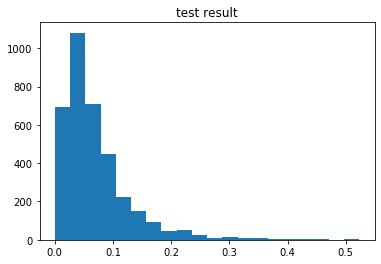

In [9]:
plt.hist(distance_test, bins=20)
plt.title('test result')

In [16]:
dist_per_surface = []
total_atoms = 0
for sdt in SDT_test:
    num_atoms = sdt[-2].shape[0]
    dist_per_surface.append(np.mean(distance_test[total_atoms: total_atoms+num_atoms]))
    total_atoms += num_atoms

In [17]:
results =[]
reduced = []
best = []
for dist, doc in zip(dist_per_surface, docs_test):
    total_steps = len(doc['distances_per_step'])
    reduced_steps = len(np.where(doc['distances_per_step'] >= dist)[0])
    results.append([total_steps, reduced_steps, reduced_steps/total_steps])
    reduced.append(reduced_steps/total_steps)

Text(0.5, 0, '% Reduced')

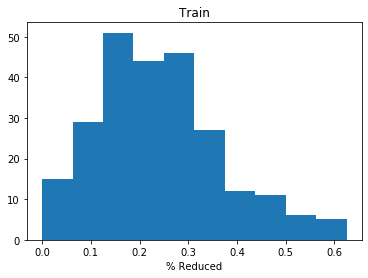

In [18]:
import matplotlib.pyplot as plt
plt.hist(reduced)
plt.title("Train")
plt.xlabel("% Reduced")

In [19]:
print(np.mean(reduced))
print(np.std(reduced))

0.23738151760454085
0.12615249681269708
